In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm as cmc
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import shape
from shapely.geometry.polygon import orient
from shapely import wkt
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import features
from rasterio.features import shapes
from IPython.display import Image, display
import contextily as cx

# compile in-situ data information

In [62]:
bs = {
    'lon': [-49.1254, -49.5345], 
    'lat': [69.5345, 69.4891], 
    'date': ['2005-08-14', '2005-08-15'],
    'depth_min': [1.05, 1.25], 
    'depth_max': [11.5, 10.0], 
    'n_obs': [335, 338],
    'accuracy_m': [0.1]*2,
    'instrument': ['Garmin Fish Finder 100']*2,
    'source': ['Box and Ski (2007)']*2,
}

sh =  {
    'lon': [-38.44996], 
    'lat': [66.46145], 
    'date': ['2008-07-11'],
    'depth_min': [0.7], 
    'depth_max': [3.0], 
    'n_obs': [21],
    'accuracy_m': [0.03],
    'instrument': ['Satlantic Profiler II'],
    'source': ['Sneed and Hamilton (2011)']
}

ts =  {
    'lon': [-49.494444], 
    'lat': [69.609722], 
    'date': ['2010-07-02, 2010-07-03, 2010-07-05'],
    'depth_min': ['n/a'], 
    'depth_max': [4.5], 
    'n_obs': [6000],
    'accuracy_m': [0.25],
    'instrument': ['HDS-5 Lowrance'],
    'source': ['Tedesco and Steiner (2011)']
}
le =  {
    'lon': [-48.32203, -48.10075, -48.76486], 
    'lat': [67.11825, 66.90250, 67.18042], 
    'date': ['2012-07-20', '2012-07-21', '2012-07-23'],
    'depth_min': ['n/a', 'n/a', 'n/a'], 
    'depth_max': [3.16, 10.45, 1.66], 
    'n_obs': [3264, 4383, 1164],
    'accuracy_m': [0.025]*3,
    'instrument': ['Ohmex SonarMite 235KHz']*3,
    'source': ['Legleiter et al. (2014)']*3
}

lu =  {
    'lon': [-21.81817, -21.92166, -21.93727], 
    'lat': [78.92271, 78.90026, 78.87014], 
    'date': ['2022-07-09', '2022-07-03', '2022-07-09'],
    'depth_min': [0.41, 0.46, 0.39], 
    'depth_max': [8.21, 6.78, 7.32], 
    'n_obs': [2129, 981, 2991],
    'accuracy_m': [0.2]*3,
    'instrument': ['Lawrence Elite 7 FS']*3,
    'source': ['Lutz et al. (2024)']*3
}

crsp = 'EPSG:3413'

dfis = pd.concat([pd.DataFrame(x) for x in [bs, sh, ts, le, lu]]).reset_index(drop=True)
gdfis = gpd.GeoDataFrame(dfis, geometry=gpd.points_from_xy(dfis.lon, dfis.lat), crs="EPSG:4326").to_crs(crsp)

# load location information

In [25]:
gdf_names = gpd.read_file('../data/shapefiles/GRE_fullnames_GIMP_merged.shp')
gdf_merged = gpd.read_file('../data/shapefiles/GRE_basins_merged_GRIMP.shp') 
gdfnp = gdf_names.to_crs(crsp)
gdfmp = gdf_merged.to_crs(crsp)

# match locations of lakes with basin names

In [65]:
def get_lake_location_name(r):
    containing_polygon = gdfnp[gdfnp.geometry.contains(r.geometry)]

    if len(containing_polygon) > 0:
        if len(containing_polygon) == 1:
            v = containing_polygon.iloc[0]
        else:
            print('%5i: WARNING - lake was assigned to two sub-basins: ' % r.name, end='')
            for subid in containing_polygon.index: 
                print('%s, ' % containing_polygon.NAME.loc[subid], end='')
            # just assign the one with the shorter name
            v = containing_polygon.loc[containing_polygon.apply(lambda x: len(x.NAME), axis=1).idxmin()]
            print(' --> assigned: %s' % v.NAME)
        return pd.DataFrame({'basin': v.SUBREGION1, 'sub_basin': v.NAME, 'glacier_type': 'tidewater' if v.GL_TYPE=='TW' else 'land_terminating'}, index=[r.name])
    else:
        print('%5i: WARNING - lake not assigned to any sub-basins' % r.name)
        return pd.DataFrame({'basin': 'none', 'sub_basin': 'none', 'glacier_type': 'none'}, index=[r.name])

cols = []
nfiles = len(gdfis)

for i, idx in enumerate(gdfis.index):
    
    if (i+1) % 100 == 0:
        print('%5i / %5i' % (i+1, nfiles), end='\r')
        
    cols.append(get_lake_location_name(gdfis.loc[idx]))

df_matched_names = pd.concat(cols).rename(columns={'basin': 'IMBIE_basin', 'sub_basin': 'IMBIE_name'})
gdf_output = pd.concat((gdfis, df_matched_names), axis=1)
df_output = gdf_output.drop(columns=['geometry'])
df_output.to_csv('insitu_obs_summary_supraglacial_lakes.csv', index=False)
display(df_output)

,lon,lat,date,depth_min,depth_max,n_obs,accuracy_m,instrument,source,IMBIE_basin,IMBIE_name,glacier_type
0,-49.125400,69.534500,2005-08-14,1.05,11.50,335,0.100,Garmin Fish Finder 100,Box and Ski (2007),CW,JAKOBSHAVN_ISBRAE,tidewater
1,-49.534500,69.489100,2005-08-15,1.25,10.00,338,0.100,Garmin Fish Finder 100,Box and Ski (2007),CW,SERMEQ_AVANNARLEQ,tidewater
2,-38.449960,66.461450,2008-07-11,0.7,3.00,21,0.030,Satlantic Profiler II,Sneed and Hamilton (2011),SE,HELHEIMGLETSCHER,tidewater
3,-49.494444,69.609722,"2010-07-02, 2010-07-03, 2010-07-05",n/a,4.50,6000,0.250,HDS-5 Lowrance,Tedesco and Steiner (2011),CW,CW_NONAME1,land_terminating
4,-48.322030,67.118250,2012-07-20,n/a,3.16,3264,0.025,Ohmex SonarMite 235KHz,Legleiter et al. (2014),SW,ISUNNGUATA-RUSSELL,land_terminating
5,-48.100750,66.902500,2012-07-21,n/a,10.45,4383,0.025,Ohmex SonarMite 235KHz,Legleiter et al. (2014),SW,SAQQAP-MAJORQAQ-SOUTHTERRUSSEL_SOUTHQUARUSSEL,land_terminating
6,-48.764860,67.180420,2012-07-23,n/a,1.66,1164,0.025,Ohmex SonarMite 235KHz,Legleiter et al. (2014),SW,ISUNNGUATA-RUSSELL,land_terminating
7,-21.818170,78.922710,2022-07-09,0.41,8.21,2129,0.200,Lawrence Elite 7 FS,Lutz et al. (2024),NE,ZACHARIAE_ISSTROM,tidewater
8,-21.921660,78.900260,2022-07-03,0.46,6.78,981,0.200,Lawrence Elite 7 FS,Lutz et al. (2024),NE,ZACHARIAE_ISSTROM,tidewater
9,-21.937270,78.870140,2022-07-09,0.39,7.32,2991,0.200,Lawrence Elite 7 FS,Lutz et al. (2024),NE,ZACHARIAE_ISSTROM,tidewater


# plot

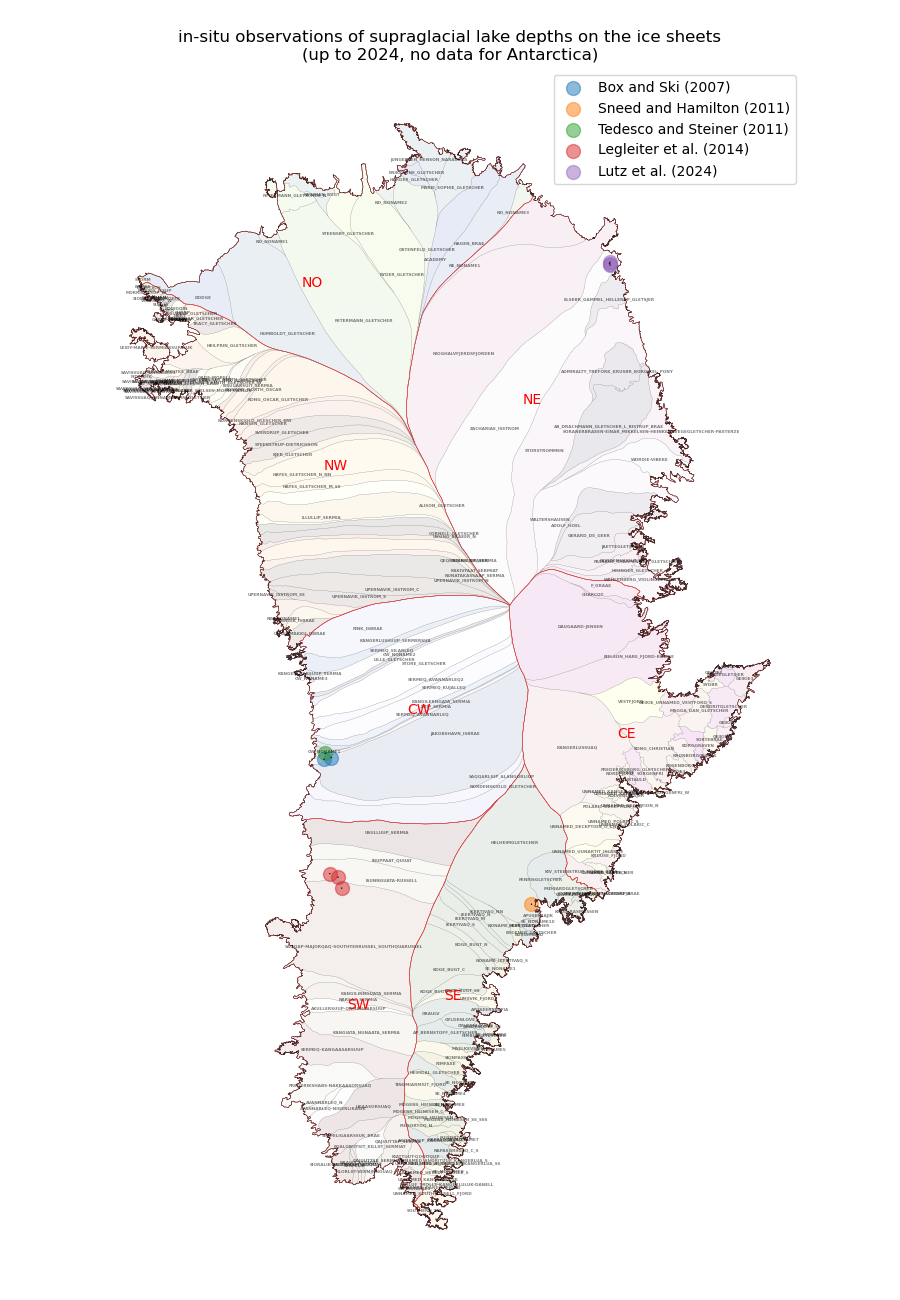

In [64]:
fig, ax = plt.subplots(figsize=[9,13])


regcms = {
    'NO': cmc.imola,
    'NW': cmc.lajolla,
    'NE': cmc.acton, 
    'CW': cmc.devon,
    'CE': cmc.buda,
    'SW': cmc.bilbao,
    'SE': cmc.bamako
}
for i, sub in enumerate(np.unique(gdfnp.SUBREGION1)):
    gdf_sub = gdfnp[gdfnp.SUBREGION1 == sub]
    gdf_sub.plot(column='NAME', cmap=regcms[sub], ax=ax, alpha=0.1)

gdfmp.boundary.plot(color='r', ax=ax, lw=0.3)
gdfmp.dissolve().boundary.plot(color='k', ax=ax, lw=0.3)
gdfnp.boundary.plot(color='gray', ax=ax, lw=0.1)
gdfnp.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.representative_point().coords[0], 
                ha='center',va='center', color='black', fontsize=3, fontweight='bold', alpha=0.5), axis=1)
gdfmp.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.representative_point().coords[0], 
                                       ha='center',va='center',color='red',fontsize=10),axis=1)

hdls = []
_, idx = np.unique(gdfis.source, return_index=True)
unique_sources = gdfis.source[np.sort(idx)]
for src in unique_sources:
    gdftp = gdfis[gdfis.source==src]
    coords = gdftp.get_coordinates()
    hdl = ax.scatter(coords.x, coords.y, s=100, alpha=0.5, label=src)
    hdls.append(hdl)
allc = gdfis.get_coordinates()
ax.scatter(allc.x, allc.y, s=1, color='k', edgecolors='none')

ax.legend(handles=hdls, loc='upper right')

ax.set_title('in-situ observations of supraglacial lake depths on the ice sheets\n(up to 2024, no data for Antarctica)')

ax.axis('off')
fig.tight_layout()

fig.savefig('../figures/supplemental-in-situ-observations.jpg', dpi=300)

In [48]:
_, idx = np.unique(gdfis.source, return_index=True)
print(gdfis.source[np.sort(idx)])

0            Box and Ski (2007)
2     Sneed and Hamilton (2011)
3    Tedesco and Steiner (2011)
4       Legleiter et al. (2014)
7            Lutz et al. (2024)
Name: source, dtype: object


In [ ]:
GlacierLakeDetectionICESat2/sonar/bbox_shapefiles/Sonar_2022-07-04_lake610a_bbox_buff_87.shp
GlacierLakeDetectionICESat2/sonar/bbox_shapefiles/Sonar_2022-07-09_lake522_bbox_buff_101.shp
GlacierLakeDetectionICESat2/sonar/bbox_shapefiles/Sonar_2022-07-09_lake610b_bbox_buff_86.shp

In [166]:
import shutil
fn = 'sonar/bbox_shapefiles/Sonar_2022-07-04_lake610a_bbox_buff_1102.shp'
gdfs = gpd.read_file(fn).to_crs(gdfp.crs).buffer(1000)
gdfs.exterior.plot(ax=ax, color='C0')
lks_within = gdfp[gdfp.within(gdfs.geometry.iloc[0])]
lks_within

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
3502,lake_099803_GrIS_2022_simplified_GRE_2200_NE_A...,good_lake,GrIS,2022,2022-08-16T10:47:25Z,-21.936378,78.902766,183.571476,1.968461,17.206128,...,0.729935,1355.0,1355.0,9.195672,7.989997,0.553623,POINT (472357.724 -1109378.459),NE,ZACHARIAE_ISSTROM,tidewater
3989,lake_099841_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-07-25T15:52:00Z,-21.906806,78.900116,190.005661,1.591644,5.501512,...,0.604937,255.0,255.0,2.698559,2.430171,0.330935,POINT (473043.833 -1109400.916),NE,ZACHARIAE_ISSTROM,tidewater


../GLD3_complete/GrIS/detection_context/good_lake/lake_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005_context.jpg
../GLD3_complete/GrIS/detection_out_data/good_lake/lake_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005.h5
sonar/IS2/Sonar_2022-07-04_lake610a_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005_context.jpg
sonar/IS2/Sonar_2022-07-04_lake610a_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005.h5


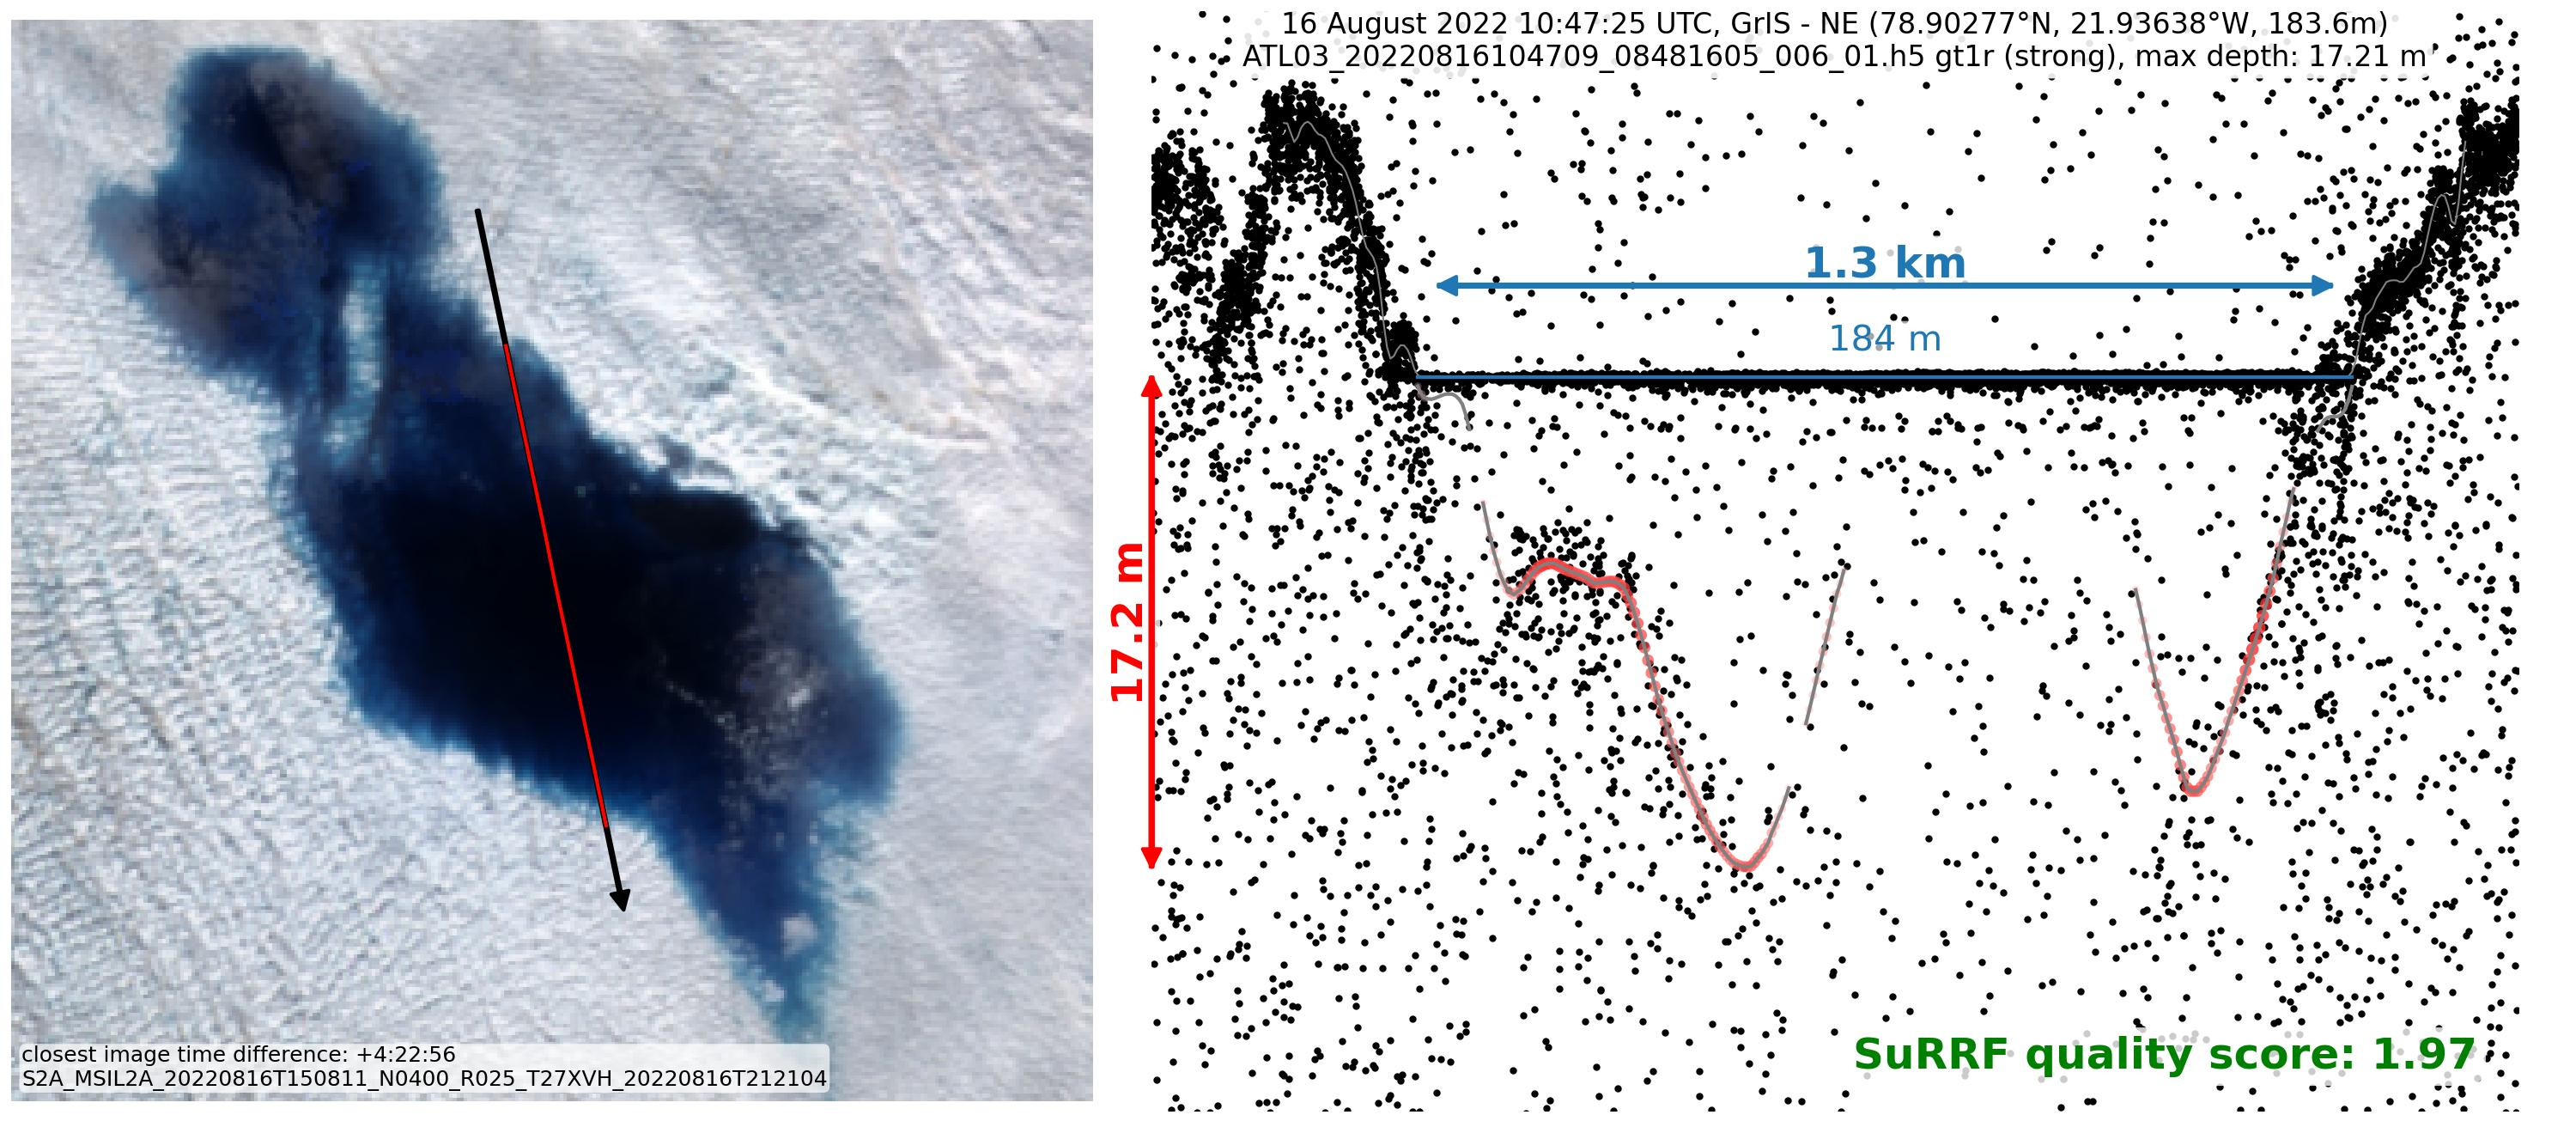

In [146]:
lk_sel = 3502
id = lks_within.loc[lk_sel].lake_id
label = lks_within.loc[lk_sel].label
fn_ql = '../GLD3_complete/GrIS/detection_context/%s/%s_context.jpg' % (label, id)
fn_h5 = '../GLD3_complete/GrIS/detection_out_data/%s/%s.h5' % (label, id)
print(fn_ql)
print(fn_h5)
path_out = 'sonar/IS2'
fn_ql_copy = path_out + fn_ql.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
fn_h5_copy = path_out + fn_h5.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
print(fn_ql_copy)
print(fn_h5_copy)
display(Image(fn_ql))
# shutil.copy(fn_ql, fn_ql_copy)
# shutil.copy(fn_h5, fn_h5_copy)

In [167]:
fn = 'sonar/bbox_shapefiles/Sonar_2022-07-09_lake522_bbox_buff_1290.shp'
gdfs = gpd.read_file(fn).to_crs(gdfp.crs).buffer(1000)
gdfs.exterior.plot(ax=ax, color='C1')
lks_within = gdfp[gdfp.within(gdfs.geometry.iloc[0])]
lks_within

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
1277,lake_099372_GrIS_2019_simplified_GRE_2200_NE_A...,good_lake,GrIS,2019,2019-06-21T17:45:22Z,-21.802226,78.925955,205.923293,6.275333,8.244040,...,0.910490,870.0,870.0,4.369849,4.496133,0.508000,POINT (473955.465 -1105939.611),NE,ZACHARIAE_ISSTROM,tidewater
1309,lake_099382_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-07-25T15:52:01Z,-21.774497,78.925682,200.293114,6.181547,12.435286,...,0.871810,1125.0,1125.0,5.055906,4.041689,0.501618,POINT (474502.424 -1105737.569),NE,ZACHARIAE_ISSTROM,tidewater
2389,lake_099670_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-07-25T15:52:00Z,-21.778538,78.925328,200.305438,3.299073,9.149508,...,0.777775,1125.0,1125.0,5.087050,5.810437,0.501618,POINT (474439.683 -1105806.542),NE,ZACHARIAE_ISSTROM,tidewater
2960,lake_099752_GrIS_2020_simplified_GRE_2200_NE_A...,good_lake,GrIS,2020,2020-06-19T00:24:35Z,-21.809304,78.923009,198.452362,2.483037,3.627835,...,0.776873,245.0,245.0,1.830510,1.671391,0.330827,POINT (473945.663 -1106294.191),NE,ZACHARIAE_ISSTROM,tidewater
3108,lake_099766_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-06-17T07:03:56Z,-21.804145,78.928281,192.294081,2.336077,4.439193,...,0.732469,225.0,225.0,2.238411,2.124743,0.345865,POINT (473818.303 -1105721.830),NE,ZACHARIAE_ISSTROM,tidewater
3659,lake_099815_GrIS_2022_simplified_GRE_2200_NE_A...,good_lake,GrIS,2022,2022-07-23T22:31:45Z,-21.774528,78.925923,195.411728,1.845184,8.311351,...,0.798609,1170.0,1170.0,3.173264,1.824061,0.335404,POINT (474491.413 -1105713.579),NE,ZACHARIAE_ISSTROM,tidewater
4756,lake_099892_GrIS_2020_simplified_GRE_2200_NE_A...,good_lake,GrIS,2020,2020-06-19T00:24:34Z,-21.805213,78.923055,198.450281,1.083039,2.302109,...,0.463584,215.0,215.0,1.161035,1.051293,0.268293,POINT (474022.665 -1106255.685),NE,ZACHARIAE_ISSTROM,tidewater
5445,lake_099925_GrIS_2023_simplified_GRE_2200_NE_A...,good_lake,GrIS,2023,2023-07-22T05:10:11Z,-21.794790,78.941188,237.429055,0.746145,1.698918,...,0.509162,110.0,110.0,1.112661,1.245367,0.147059,POINT (473442.938 -1104347.773),NE,ZACHARIAE_ISSTROM,tidewater
6781,lake_099982_GrIS_2023_simplified_GRE_2200_NE_A...,good_lake,GrIS,2023,2023-07-22T05:10:11Z,-21.774067,78.925254,195.102156,0.175239,0.751239,...,0.216600,1185.0,1185.0,1.323408,0.800862,0.215434,POINT (474529.195 -1105777.026),NE,ZACHARIAE_ISSTROM,tidewater
6844,lake_099985_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-06-17T07:03:56Z,-21.804998,78.923322,191.210730,0.145396,4.306538,...,0.441441,205.0,205.0,2.538936,2.702244,0.311111,POINT (474015.330 -1106227.140),NE,ZACHARIAE_ISSTROM,tidewater


../GLD3_complete/GrIS/detection_context/good_lake/lake_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010_context.jpg
../GLD3_complete/GrIS/detection_out_data/good_lake/lake_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010.h5
sonar/IS2/Sonar_2022-07-09_lake522_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010_context.jpg
sonar/IS2/Sonar_2022-07-09_lake522_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010.h5


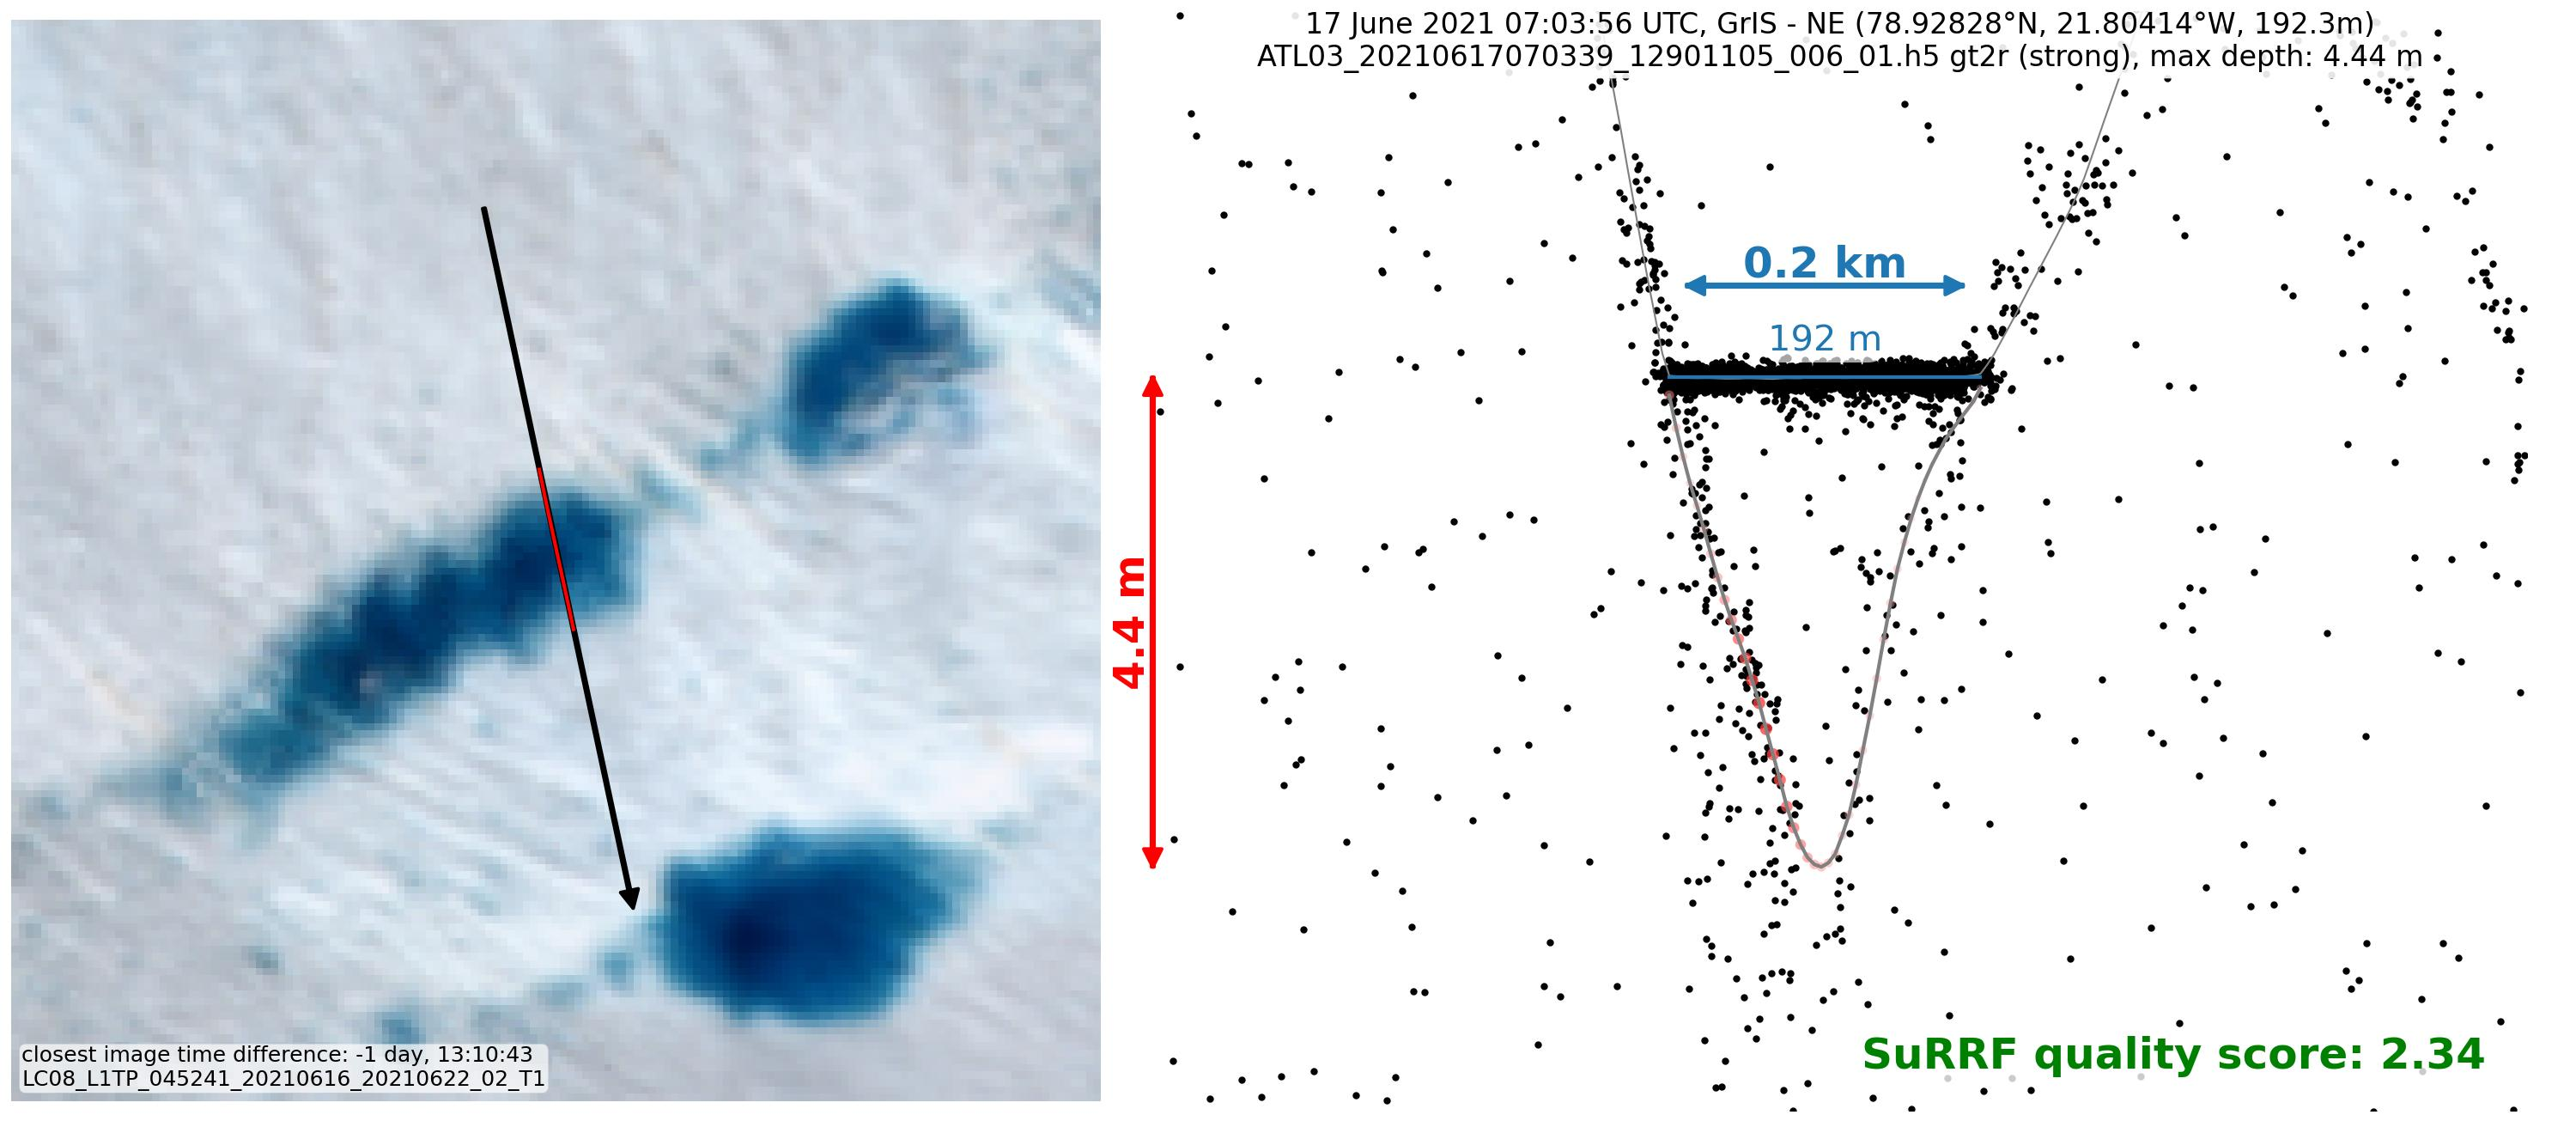

'sonar/IS2/Sonar_2022-07-09_lake522_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010.h5'

In [164]:
lk_sel = 3108
id = lks_within.loc[lk_sel].lake_id
label = lks_within.loc[lk_sel].label
fn_ql = '../GLD3_complete/GrIS/detection_context/%s/%s_context.jpg' % (label, id)
fn_h5 = '../GLD3_complete/GrIS/detection_out_data/%s/%s.h5' % (label, id)
print(fn_ql)
print(fn_h5)
path_out = 'sonar/IS2'
fn_ql_copy = path_out + fn_ql.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
fn_h5_copy = path_out + fn_h5.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
print(fn_ql_copy)
print(fn_h5_copy)
display(Image(fn_ql))
# shutil.copy(fn_ql, fn_ql_copy)
# shutil.copy(fn_h5, fn_h5_copy)

In [168]:
fn = 'sonar/bbox_shapefiles/Sonar_2022-07-09_lake610b_bbox_buff_1091.shp'
gdfs = gpd.read_file(fn).to_crs(gdfp.crs).buffer(1000)
gdfs.exterior.plot(ax=ax, color='C2')
lks_within = gdfp[gdfp.within(gdfs.geometry.iloc[0])]
lks_within

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
2115,lake_099624_GrIS_2020_simplified_GRE_2200_NE_A...,good_lake,GrIS,2020,2020-06-19T00:24:35Z,-22.011183,78.871621,245.021207,3.758562,6.710472,...,0.770134,390.0,390.0,2.989694,2.638781,0.477707,POINT (472238.526 -1113128.279),NE,ZACHARIAE_ISSTROM,tidewater
2215,lake_099641_GrIS_2019_simplified_GRE_2200_NE_A...,good_lake,GrIS,2019,2019-06-21T17:45:23Z,-22.011814,78.871192,247.555856,3.589591,3.186744,...,0.845590,270.0,270.0,1.905831,2.052988,0.413534,POINT (472244.596 -1113176.676),NE,ZACHARIAE_ISSTROM,tidewater
8064,lake_099982_GrIS_2021_simplified_GRE_2200_NE_A...,lake_bad_depth,GrIS,2021,2021-06-17T07:03:57Z,-22.011171,78.871767,240.201185,0.180542,3.210563,...,0.348435,285.0,285.0,2.265161,2.507320,0.255814,POINT (472232.571 -1113113.547),NE,ZACHARIAE_ISSTROM,tidewater


../GLD3_complete/GrIS/detection_context/good_lake/lake_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027_context.jpg
../GLD3_complete/GrIS/detection_out_data/good_lake/lake_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027.h5
sonar/IS2/Sonar_2022-07-09_lake610b_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027_context.jpg
sonar/IS2/Sonar_2022-07-09_lake610b_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027.h5


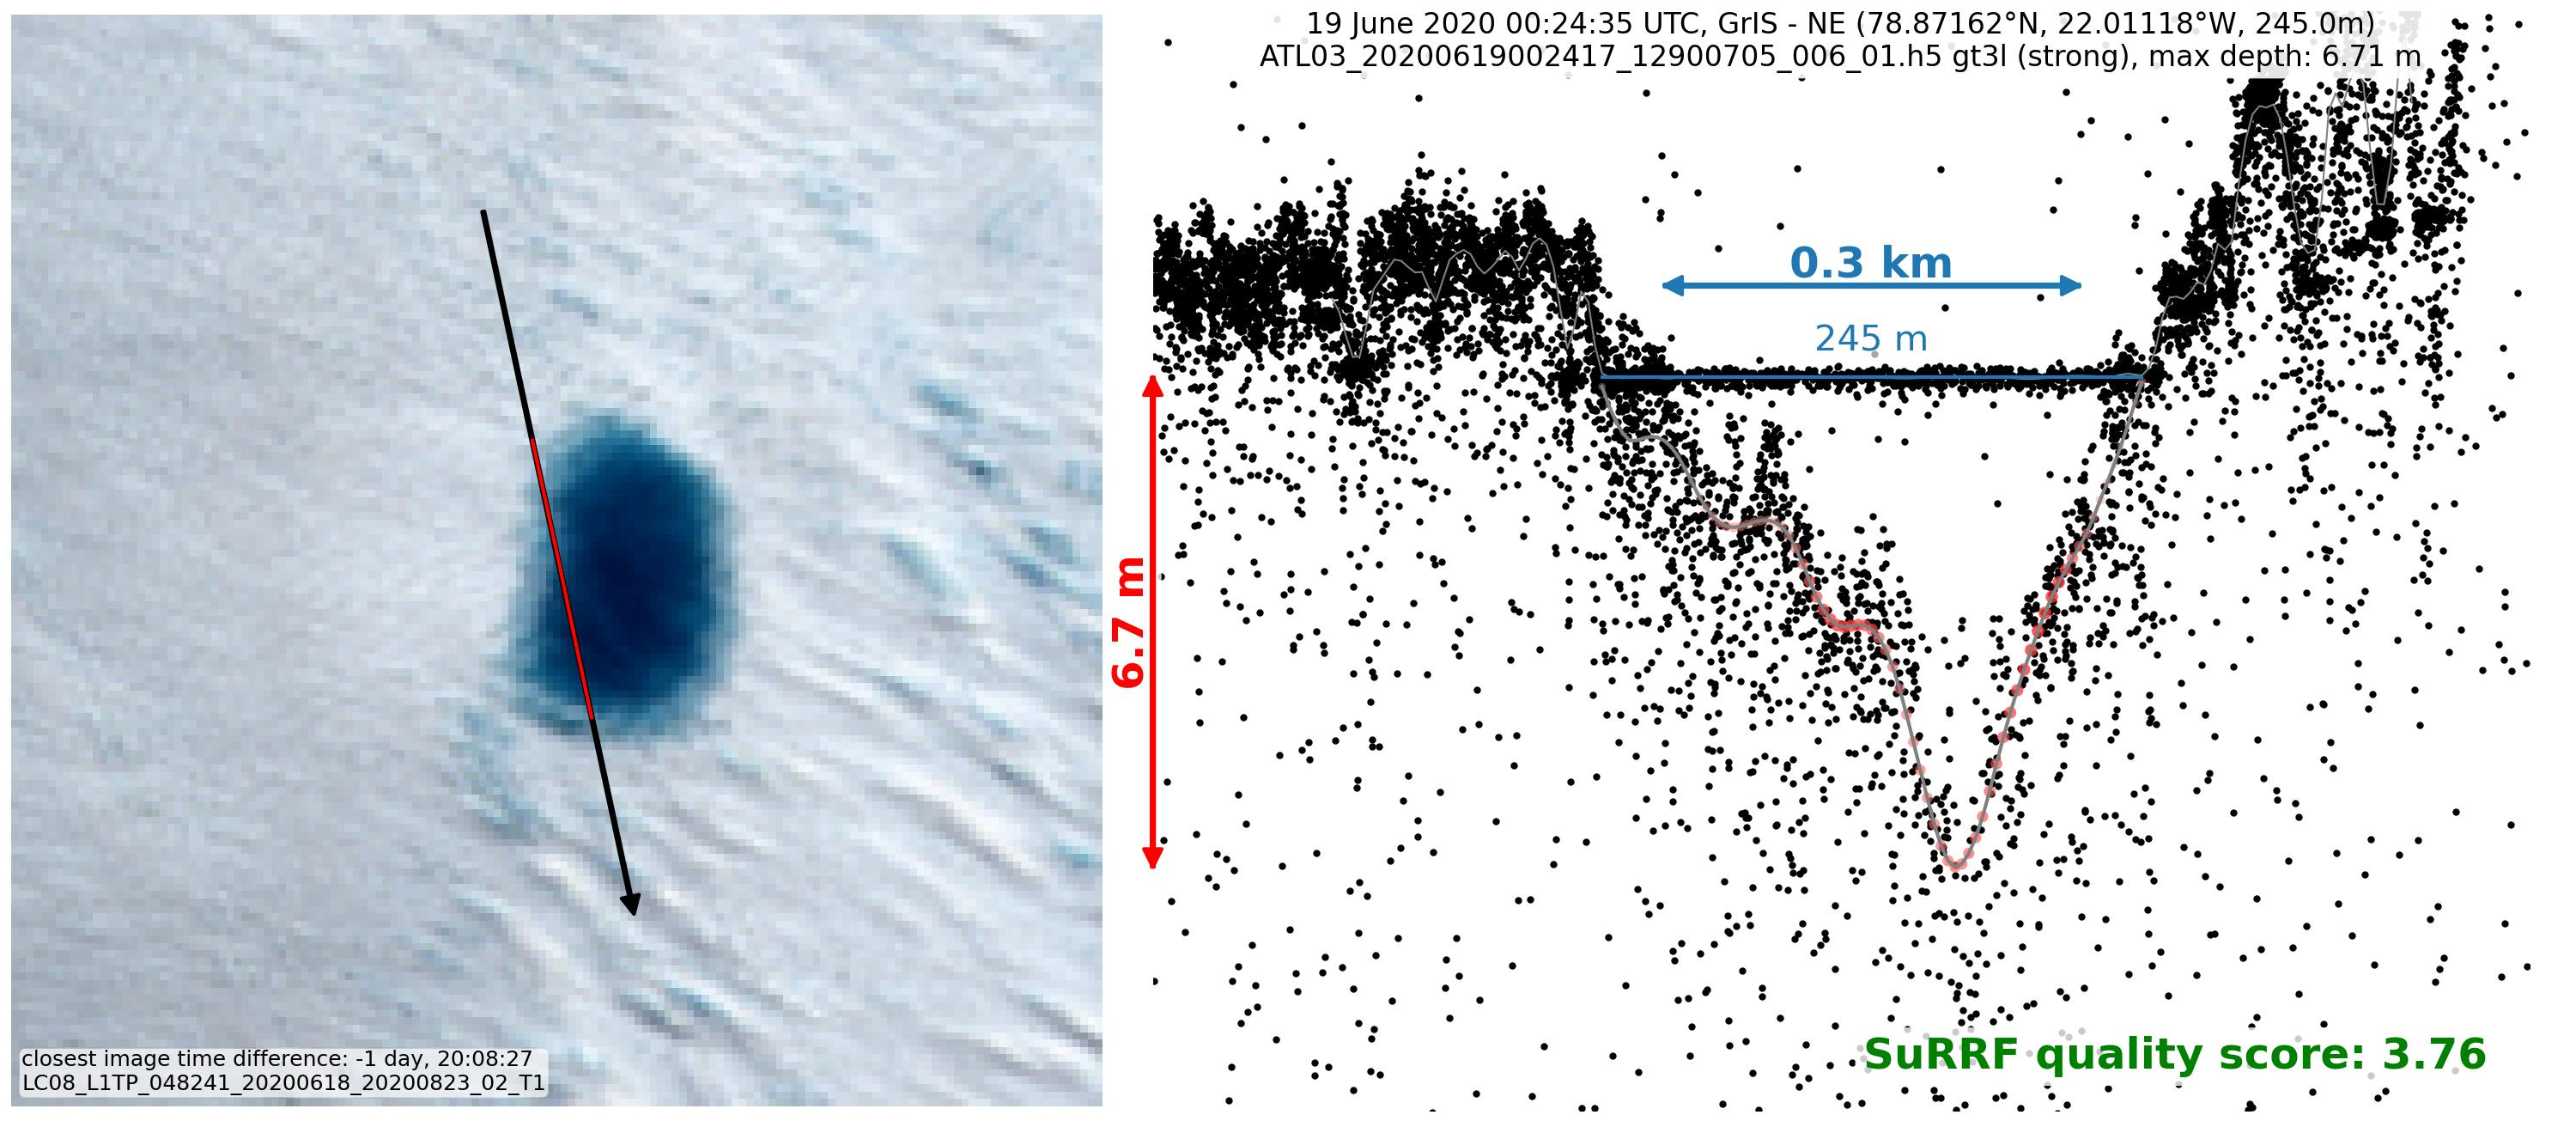

In [171]:
lk_sel = 2115
id = lks_within.loc[lk_sel].lake_id
label = lks_within.loc[lk_sel].label
fn_ql = '../GLD3_complete/GrIS/detection_context/%s/%s_context.jpg' % (label, id)
fn_h5 = '../GLD3_complete/GrIS/detection_out_data/%s/%s.h5' % (label, id)
print(fn_ql)
print(fn_h5)
path_out = 'sonar/IS2'
fn_ql_copy = path_out + fn_ql.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
fn_h5_copy = path_out + fn_h5.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
print(fn_ql_copy)
print(fn_h5_copy)
display(Image(fn_ql))
# shutil.copy(fn_ql, fn_ql_copy)
# shutil.copy(fn_h5, fn_h5_copy)

In [103]:
'sonar/bbox_shapefiles/Sonar_2022-07-09_lake522_bbox_buff_1290.shp'
'sonar/bbox_shapefiles/Sonar_2022-07-09_lake610b_bbox_buff_1091.shp'

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-18T03:49:28Z,-49.895976,70.437430,863.975706,3.414623e+14,11.845931,...,0.881645,190.0,190.0,8.857334,9.038176,0.317073,POINT (-182570.637 -2131353.286),CW,STORE_GLETSCHER,tidewater
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,GrIS,2019,2019-08-01T03:14:32Z,-29.452426,72.077225,1576.515319,1.398473e+02,8.264746,...,0.953027,360.0,360.0,5.463883,5.645384,0.467949,POINT (524517.511 -1885268.990),CE,CHARCOT,tidewater
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:44Z,-48.989571,70.329607,1440.634057,1.388842e+02,4.654427,...,0.989059,610.0,610.0,3.056169,3.253488,0.600000,POINT (-149667.695 -2145960.954),CW,SERMEQ_AVANNARLEQ2,tidewater
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:22Z,-48.429319,68.981759,1185.275591,1.002200e+02,13.051067,...,0.936802,1550.0,1550.0,8.801961,9.312227,0.787342,POINT (-137681.131 -2297577.567),CW,JAKOBSHAVN_ISBRAE,tidewater
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:22Z,-48.431568,68.981906,1185.287005,8.950596e+01,12.472857,...,0.968607,1580.0,1580.0,8.292133,9.113540,0.810742,POINT (-137770.357 -2297555.766),CW,JAKOBSHAVN_ISBRAE,tidewater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8781,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-10T06:24:01Z,-47.414714,62.403165,1923.015047,0.000000e+00,0.000000,...,0.035883,50.0,50.0,1.633294,1.634690,0.047414,POINT (-128348.463 -3043619.143),SW,UKAASORSUAQ,tidewater
8782,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:30:07Z,-47.991343,63.598828,2077.807601,0.000000e+00,0.000000,...,0.064884,0.0,NaN,NaN,NaN,0.000000,POINT (-151838.997 -2905660.717),SW,SERMEQ-KANGAASARSUUP,land_terminating
8783,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:30:01Z,-47.908601,63.945830,2060.941824,0.000000e+00,0.000000,...,0.032632,0.0,0.0,0.001750,0.001750,0.003546,POINT (-145635.807 -2866377.588),SW,KANGIATA_NUNAATA_SERMIA,tidewater
8784,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:29:59Z,-47.939633,64.079196,1975.356456,0.000000e+00,0.000000,...,0.042076,145.0,145.0,0.243763,0.256994,0.031579,POINT (-146409.425 -2851131.789),SW,KANGIATA_NUNAATA_SERMIA,tidewater
